# Digital Gate Driver

4/20/25

Mia Chevere, Allyson Hur, Drew Pang


## Design Requirments

We used the following design requirements when selecting a replacement gate driver.

1. Inverting/non-inverting
2. Input threshold (VIL/VIH)
3. Bias supply voltage (VDD)
4. Peak current
5. Device-specific configuration

These design requirements are loosely based on those listed in page 24 of the UCC27531 datasheet: https://www.ti.com/lit/ds/symlink/ucc27531.pdf#page=24

### Inverting/Non-Inverting

The distinction between inverting and non-inverting does not particularly matter, since we can invert the output of the PWM signal from the FPGA. There are important details realted to switching time and switching losses with inverting/non-inverting that could be considered, but due to limited time we will not explore those here. For simlicity, we will use a non-inverting gate driver.

**Selection: Non-inverting**

### Input Threshold

The FPGA development board we are using is the Cmod A7, which operates at a 3V3 logic level. For VIL and VIH, any voltage between 0 and 3V3 is sufficient, with VIL $<$ VIH

**Selection: 0V < VIL < VIH < 3V3**



### Bias Supply Voltage (VDD)

The bias supply voltage is the voltage the gate driver will supply to the MOSEFET gate. For our lab hardware, this voltage is the same as the input voltage, and a new gate driver must be able to handle at least 18V as the bias supply voltage.

**Selection: >18V**

### Peak Current

The peak current is largely determined by the external gate driver resistor and gate charge and can be estimated three ways:

1. From MOSFET gate voltage data from lab 3
2. From gate resistor voltage data from lab 3
3. From gate resistor and MOSFET gate charge

Since we already have the gate driver resistor current from lab 3, we can use that as a baseline for the peak current we should expect of our new gate driver.

TODO: Q: Why do some gate drivers have different peak current ratings for source/sink?

##### MOSFET Gate Current from Lab 3

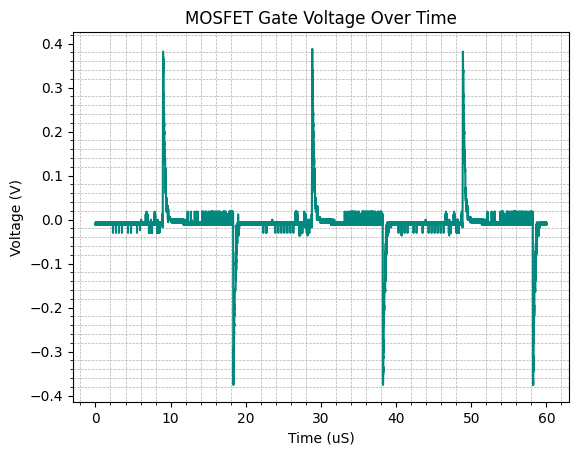

In [20]:
import sys
import os
import matplotlib.pyplot as plt
sys.path.append(os.path.abspath('../'))

from util.lab_util import import_scope_data, truncate_scope_data, TimeStepUnits
from util.lab_util import light_sea_green, bittersweet, black, electric_blue

gate_driver_resistor = 33 # ohms
lab3_9v_gate = truncate_scope_data(import_scope_data("documentation/data/lab3_9v_gate.csv", num_channels=2, units=TimeStepUnits.us), start=0, end=None, phase_shift=0)
lab3_9v_gate.channel_data[0] = [data - 20.5 for data in lab3_9v_gate.channel_data[0]]
mosfet_gate_current = [(gate_driver - gate) / gate_driver_resistor for gate, gate_driver in zip(lab3_9v_gate.channel_data[0], lab3_9v_gate.channel_data[1])]

plt.figure()
plt.title("MOSFET Gate Voltage Over Time")
plt.xlabel("Time (uS)")
plt.ylabel("Voltage (V)")
plt.plot(lab3_9v_gate.time, mosfet_gate_current, color=light_sea_green)
plt.minorticks_on()
plt.grid(which="minor", linestyle="--", linewidth=0.5)
plt.show()

With a gate resistor of 33 Ohms and a MOSFET with a gate charge of 90 nC, the peak current sourced and sink by the UC2844 was around 0.4A. Our new gate driver must accommodate this.

**Selection: Peak source/sink current of at least 0.6A**

### Selected Gate Driver: UCC27531

The UCC27531 was selected because it is a relatively modern digital gate driver that meets all of the specifications above.

1. Inverting/non-inverting: **NON-INVERTING**
2. Input threshold (VIL/VIH) **VIL = 1, VIH = 2 TYP**
3. Bias supply voltage (VDD) **32V MAX**
4. Peak current **2.5A SOURCE, 5A SINK**
5. Device-specific configuration **SEE BELOW**

Because the peak gate driver current is significantly higher than required, we can reduce the gate driver resistor to increase switching time and decrease switching losses.

##### Device-Specific Configuration
\
There exist numerous variations of the UCC2753x gate driver.

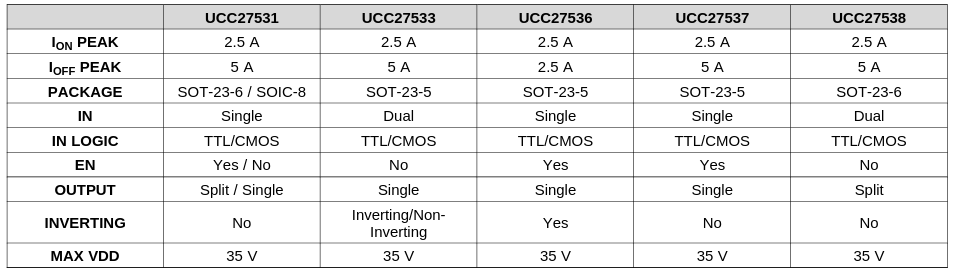

The UCC27531 and UCC27537 are the same, except the UCC27531 has a split output to reduce ground debouncing. We may use this, but if not we will have a jumper connecting the split output into a single output.

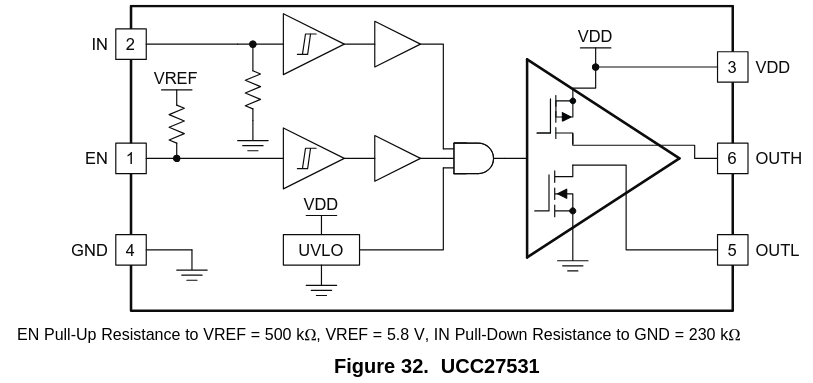

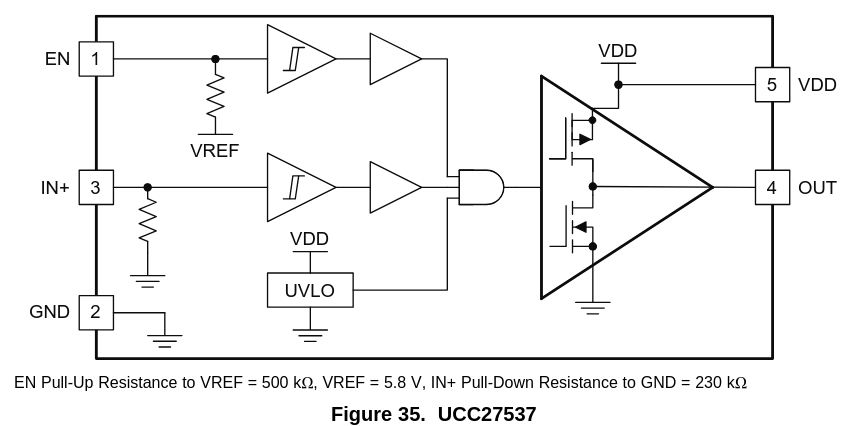

### Appendix: Resources

- "Selecting Gate Driver Tutorial", Diodes Inc: https://www.mouser.com/pdfdocs/Selecting-Gate-Driver-Tutorial.pdf
- "UCC2753x 2.5-A and 5-A, 35-VMAX VDD FET and IGBT Single-Gate Driver", Texas Instruments: https://www.ti.com/lit/ds/symlink/ucc27531.pdf
- "How Fast Does a MOSFET Gate Driver Need to Be?", Cadence: https://resources.pcb.cadence.com/blog/how-fast-does-a-mosfet-gate-driver-need-to-be